[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bertoldi-collab/jax-intro/blob/main/notebooks/1D_mass_spring_chain.ipynb)


# JAX-based 1D chain


## Imports and helper functions

In [4]:
from IPython.display import HTML
from matplotlib import animation
import matplotlib.pyplot as plt
import jax.numpy as jnp
from jax import grad, jit, vmap, jacobian
from jax import random
from jax.experimental.ode import odeint
from jax import config
config.update("jax_enable_x64", True)  # enable float64 type


def generate_animation(solution):
    fig, axes = plt.subplots()
    plot, = axes.plot(solution[0, 0, :], color="black", marker="o",
                      markerfacecolor="blue", markeredgecolor="blue", markersize=10)
    axes.set_xlabel("Mass #")
    axes.set_ylabel("Displacement")
    axes.set_xticks(jnp.arange(solution.shape[-1]))

    def animate(i):
        plot.set_ydata(solution[i, 0, :])
        return plot,

    fig.tight_layout()
    ani = animation.FuncAnimation(
        fig, animate, frames=solution.shape[0], blit=True, interval=20)
    plt.close(fig)

    return ani

## Energy and force

In [2]:
def potential_energy(displacement, stiffness):
    # NOTE: This can be anything
    return 0.5 * jnp.sum(stiffness * jnp.diff(displacement)**2, axis=-1)


def kinetic_energy(velocity, mass):
    return 0.5 * jnp.sum(mass * velocity**2, axis=-1)


force = grad(lambda displacement, stiffness: -
             potential_energy(displacement, stiffness))

## Test force


In [3]:
n_masses = 5  # number of masses in the chain
force(
    jnp.linspace(0, 1, n_masses),  # Linear displacements
    jnp.ones(n_masses - 1),       # Constant stiffness
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


Array([ 0.25,  0.  ,  0.  ,  0.  , -0.25], dtype=float64)

In [5]:
n_masses = 5  # number of masses in the chain
force(
    jnp.linspace(0, 1, n_masses)**2,  # Quadratic displacements
    jnp.ones(n_masses - 1),           # Constant stiffness
)


Array([ 0.0625,  0.125 ,  0.125 ,  0.125 , -0.4375], dtype=float64)

## Dynamics


We are going to setup a first order system of ODEs describing the dynamics of the system i.e. $\dot x = \text{RHS}(x, t)$.
\begin{align}
\dot u &= v\\
\dot v &= \frac{f_\text{springs}}{m}
\end{align}
where $f_\text{springs}$ is the `force` function defined above and $m$ is an array of mass values.

### RHS

In [6]:
@jit
def rhs(
    state,      # current displacement and velocity
    t,          # current time
    mass,       # mass values
    stiffness,  # stiffness values
):

    displacement, velocity = state
    return jnp.array([
        velocity,
        force(displacement, stiffness) / mass
    ])

### ODE solver

In [7]:
def solve_dynamics(state0, ts, mass, stiffness):
    return odeint(rhs, state0, ts, mass, stiffness)   # RK45

## Simulation


### Define parameters

In [8]:
n_masses = 5                            # number of masses in the chain
state0 = jnp.array([
    jnp.linspace(0, 1, n_masses),       # initial displacement
    jnp.zeros((n_masses,))              # initial velocity
])
mass = jnp.ones((n_masses,))            # mass values
stiffness = jnp.ones((n_masses - 1,))   # stiffness values
ts = jnp.linspace(0, 20, 200)           # timepoints

print(f"state0 is an array of shape {state0.shape}")
print(f"mass is an array of shape {mass.shape}")
print(f"stiffness is an array of shape {stiffness.shape}")
print(f"ts is an array of shape {ts.shape}")

state0 is an array of shape (2, 5)
mass is an array of shape (5,)
stiffness is an array of shape (4,)
ts is an array of shape (200,)


### Run

In [9]:
solution = solve_dynamics(state0=state0, ts=ts, mass=mass, stiffness=stiffness)
solution.shape

(200, 2, 5)

## Plots

### Masses' motion

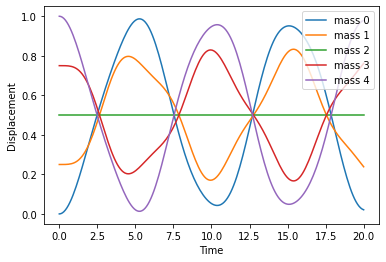

In [10]:
for i in range(n_masses):
    plt.plot(ts, solution[:, 0, i], label=f"mass {i}")

plt.xlabel("Time")
plt.ylabel("Displacement")
plt.legend()

In [11]:
HTML(generate_animation(solution).to_html5_video())

### Energies

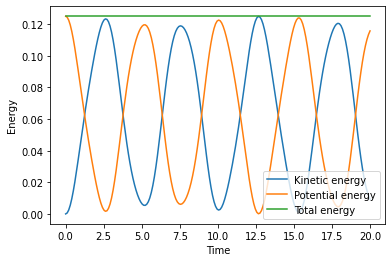

In [12]:
plt.plot(ts, kinetic_energy(solution[:, 1, :], mass), label="Kinetic energy")
plt.plot(ts, potential_energy(
    solution[:, 0, :], stiffness), label="Potential energy")
plt.plot(ts, kinetic_energy(solution[:, 1, :], mass) + potential_energy(
    solution[:, 0, :], stiffness), label="Total energy")
plt.xlabel("Time")
plt.ylabel("Energy")
plt.legend(loc="lower right")

## Differentiation through ODE solver

The solver function `solve_dynamics(state0, ts, mass, stiffness)` can be differentiated wrt the paramater of the system i.e. `mass` and `stiffness`.

In [13]:
# Derivative of the response wrt to stiffness values
dy_dk = jacobian(solve_dynamics, argnums=3)

dy_dk(state0, ts, mass, stiffness).shape

(200, 2, 5, 4)